
<a id='lqc'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# LQ Dynamic Programming Problems


<a id='index-0'></a>

## Colab Instructions

Colab does not have direct Julia support, and it must be installed each time you are working on a notebook.  

Instructions:

1. Ignore any errors about a missing kernel when loading the notebook.  Choose `Run Anyway` when it prompts that the notebook wasn't authored by google.

2. Run the cell below this with `Shift+Enter`.
    -  It will **5 to 8 minutes** the first time you run it for Julia and key packages to install

3. Refresh your browser, and then execute any code as normal.
  - Even after installation, there will be more precompiling latency for some packages. 

In [ ]:
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
    julia -e 'using Pkg; pkg"add IJulia InstantiateFromURL; precompile;"'
    julia -e 'using InstantiateFromURL; github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0", instantiate = true, precompile = false); using Plots, Distributions, Parameters, NLsolve, ForwardDiff, Expectations'
    echo 'Done'
fi


## Contents

- [LQ Dynamic Programming Problems](#LQ-Dynamic-Programming-Problems)  
  - [Overview](#Overview)  
  - [Introduction](#Introduction)  
  - [Optimality – Finite Horizon](#Optimality-–-Finite-Horizon)  
  - [Implementation](#Implementation)  
  - [Extensions and Comments](#Extensions-and-Comments)  
  - [Further Applications](#Further-Applications)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

Linear quadratic (LQ) control refers to a class of dynamic optimization problems that have found applications in almost every scientific field.

This lecture provides an introduction to LQ control and its economic applications.

As we will see, LQ systems have a simple structure that makes them an excellent workhorse for a wide variety of economic problems.

Moreover, while the linear-quadratic structure is restrictive, it is in fact far more flexible than it may appear initially.

These themes appear repeatedly below.

Mathematically, LQ control problems are closely related to [the Kalman filter](../tools_and_techniques/kalman.html).

- Recursive formulations of linear-quadratic control problems and Kalman filtering problems both involve matrix **Riccati equations**.  
- Classical formulations of linear control and linear filtering problems make use of similar matrix decompositions (see for example [this lecture](../time_series_models/lu_tricks.html) and [this lecture](../time_series_models/classical_filtering.html)).  


In reading what follows, it will be useful to have some familiarity with

- matrix manipulations  
- vectors of random variables  
- dynamic programming and the Bellman equation (see for example [this lecture](short_path.html) and [this lecture](optgrowth.html))  


For additional reading on LQ control, see, for example,

- [[LS18]](../zreferences.html#ljungqvist2012), chapter 5  
- [[HS08]](../zreferences.html#hansensargent2008), chapter 4  
- [[HLL96]](../zreferences.html#hernandezlermalasserre1996), section 3.5  


In order to focus on computation, we leave longer proofs to these sources (while trying to provide as much intuition as possible).

## Introduction

The “linear” part of LQ is a linear law of motion for the state, while the “quadratic” part refers to preferences.

Let’s begin with the former, move on to the latter, and then put them together into an optimization problem.

### The Law of Motion

Let $ x_t $ be a vector describing the state of some economic system.

Suppose that $ x_t $ follows a linear law of motion given by


<a id='equation-lq-lom'></a>
$$
x_{t+1} = A x_t + B u_t + C w_{t+1},
\qquad t = 0, 1, 2, \ldots \tag{1}
$$

Here

- $ u_t $ is a “control” vector, incorporating choices available to a decision maker confronting the current state $ x_t $.  
- $ \{w_t\} $ is an uncorrelated zero mean shock process satisfying $ \mathbb E w_t w_t' = I $, where the right-hand side is the identity matrix.  


Regarding the dimensions

- $ x_t $ is $ n \times 1 $, $ A $ is $ n \times n $  
- $ u_t $ is $ k \times 1 $, $ B $ is $ n \times k $  
- $ w_t $ is $ j \times 1 $, $ C $ is $ n \times j $  

#### Example 1

Consider a household budget constraint given by

$$
a_{t+1} + c_t = (1 + r) a_t + y_t
$$

Here $ a_t $ is assets, $ r $ is a fixed interest rate, $ c_t $ is
current consumption, and $ y_t $ is current non-financial income.

If we suppose that $ \{ y_t \} $ is serially uncorrelated and $ N(0,
\sigma^2) $, then, taking $ \{ w_t \} $ to be standard normal, we can write
the system as

$$
a_{t+1} = (1 + r) a_t - c_t + \sigma w_{t+1}
$$

This is clearly a special case of [(1)](#equation-lq-lom), with assets being the state and consumption being the control.


<a id='lq-hhp'></a>

#### Example 2

One unrealistic feature of the previous model is that non-financial income has a zero mean and is often negative.

This can easily be overcome by adding a sufficiently large mean.

Hence in this example we take $ y_t = \sigma w_{t+1} + \mu $ for some positive real number $ \mu $.

Another alteration that’s useful to introduce (we’ll see why soon) is to
change the control variable from consumption
to the deviation of consumption from some “ideal” quantity $ \bar c $.

(Most parameterizations will be such that $ \bar c $ is large relative to the amount of consumption that is attainable in each period, and hence the household wants to increase consumption)

For this reason, we now take our control to be $ u_t := c_t - \bar c $.

In terms of these variables, the budget constraint $ a_{t+1} = (1 + r) a_t - c_t + y_t $ becomes


<a id='equation-lq-lomwc'></a>
$$
a_{t+1} = (1 + r) a_t - u_t - \bar c + \sigma w_{t+1} + \mu \tag{2}
$$

How can we write this new system in the form of equation [(1)](#equation-lq-lom)?

If, as in the previous example, we take $ a_t $ as the state, then we run into a problem:
the law of motion contains some constant terms on the right-hand side.

This means that we are dealing with an *affine* function, not a linear one
(recall [this discussion](../tools_and_techniques/linear_algebra.html#la-linear-map)).

Fortunately, we can easily circumvent this problem by adding an extra state variable.

In particular, if we write


<a id='equation-lq-lowmc'></a>
$$
\left(
\begin{array}{c}
a_{t+1} \\
1
\end{array}
\right) =
\left(
\begin{array}{cc}
1 + r & -\bar c + \mu \\
0     & 1
\end{array}
\right)
\left(
\begin{array}{c}
a_t \\
1
\end{array}
\right) +
\left(
\begin{array}{c}    -1 \\
0
\end{array}
\right)
u_t +
\left(
\begin{array}{c}
\sigma \\
0
\end{array}
\right)
w_{t+1} \tag{3}
$$

then the first row is equivalent to [(2)](#equation-lq-lomwc).

Moreover, the model is now linear, and can be written in the form of
[(1)](#equation-lq-lom) by setting


<a id='equation-lq-lowmc2'></a>
$$
x_t :=
\left(
\begin{array}{c}
a_t \\
1
\end{array}
\right),
\quad
A :=
\left(
\begin{array}{cc}
1 + r & -\bar c + \mu \\
0     & 1
\end{array}
\right),
\quad
B :=
\left(
\begin{array}{c}
-1 \\
0
\end{array}
\right),
\quad
C :=
\left(
\begin{array}{c}
\sigma \\
0
\end{array}
\right) \tag{4}
$$

In effect, we’ve bought ourselves linearity by adding another state.

### Preferences

In the LQ model, the aim is to minimize a flow of losses, where time-$ t $ loss is given by the quadratic expression


<a id='equation-lq-pref-flow'></a>
$$
x_t' R x_t + u_t' Q u_t \tag{5}
$$

Here

- $ R $ is assumed to be $ n \times n $, symmetric and nonnegative definite  
- $ Q $ is assumed to be $ k \times k $, symmetric and positive definite  


>**Note**
>
>In fact, for many economic problems, the definiteness conditions on $ R $ and $ Q $ can be relaxed.  It is sufficient that certain submatrices of $ R $ and $ Q $ be nonnegative definite. See [[HS08]](../zreferences.html#hansensargent2008) for details

#### Example 1

A very simple example that satisfies these assumptions is to take $ R $
and $ Q $ to be identity matrices, so that current loss is

$$
x_t' I x_t + u_t' I u_t = \| x_t \|^2 + \| u_t \|^2
$$

Thus, for both the state and the control, loss is measured as squared distance from the origin.

(In fact the general case [(5)](#equation-lq-pref-flow) can also be understood in this
way, but with $ R $ and $ Q $ identifying other – non-Euclidean – notions of “distance” from the zero vector).

Intuitively, we can often think of the state $ x_t $ as representing deviation from a target, such
as

- deviation of inflation from some target level  
- deviation of a firm’s capital stock from some desired quantity  


The aim is to put the state close to the target, while using  controls parsimoniously.

#### Example 2

In the household problem [studied above](#lq-hhp), setting $ R=0 $
and $ Q=1 $ yields preferences

$$
x_t' R x_t + u_t' Q u_t = u_t^2 = (c_t - \bar c)^2
$$

Under this specification, the household’s current loss is the squared deviation of consumption from the ideal level $ \bar c $.

## Optimality – Finite Horizon


<a id='index-1'></a>
Let’s now be precise about the optimization problem we wish to consider, and look at how to solve it.

### The Objective

We will begin with the finite horizon case, with terminal time $ T \in \mathbb N $.

In this case, the aim is to choose a sequence of controls $ \{u_0, \ldots, u_{T-1}\} $ to minimize the objective


<a id='equation-lq-object'></a>
$$
\mathbb E \,
\left\{
    \sum_{t=0}^{T-1} \beta^t (x_t' R x_t + u_t' Q u_t) + \beta^T x_T' R_f x_T
\right\} \tag{6}
$$

subject to the law of motion [(1)](#equation-lq-lom) and initial state $ x_0 $.

The new objects introduced here are $ \beta $ and the matrix $ R_f $.

The scalar $ \beta $ is the discount factor, while $ x' R_f x $ gives terminal loss associated with state $ x $.

Comments:

- We assume $ R_f $ to be $ n \times n $, symmetric and nonnegative definite  
- We allow $ \beta = 1 $, and hence include the undiscounted case  
- $ x_0 $ may itself be random, in which case we require it to be independent of the shock sequence $ w_1, \ldots, w_T $  



<a id='lq-cp'></a>

### Information

There’s one constraint we’ve neglected to mention so far, which is that the
decision maker who solves this LQ problem knows only the present and the past,
not the future.

To clarify this point, consider the sequence of controls $ \{u_0, \ldots, u_{T-1}\} $.

When choosing these controls, the decision maker is permitted to take into account the effects of the shocks
$ \{w_1, \ldots, w_T\} $ on the system.

However, it is typically assumed — and will be assumed here — that the
time-$ t $ control $ u_t $ can  be made with knowledge of past and
present shocks only.

The fancy [measure-theoretic](https://en.wikipedia.org/wiki/Measure_%28mathematics%29) way of saying this is that $ u_t $ must be measurable with respect to the $ \sigma $-algebra generated by $ x_0, w_1, w_2,
\ldots, w_t $.

This is in fact equivalent to stating that $ u_t $ can be written in the form $ u_t = g_t(x_0, w_1, w_2, \ldots, w_t) $ for some Borel measurable function $ g_t $.

(Just about every function that’s useful for applications is Borel measurable,
so, for the purposes of intuition, you can read that last phrase as “for some function $ g_t $”).

Now note that $ x_t $ will ultimately depend on the realizations of $ x_0, w_1, w_2, \ldots, w_t $.

In fact it turns out that $ x_t $ summarizes all the information about  these historical  shocks that the decision maker needs to set controls optimally.

More precisely, it can be shown that any optimal control $ u_t $ can always be written as a function of the current state alone.

Hence in what follows we restrict attention to control policies (i.e., functions) of the form $ u_t = g_t(x_t) $.

Actually, the preceding discussion applies to all standard dynamic programming problems.

What’s special about the LQ case is that – as we shall soon see —  the optimal $ u_t $ turns out to be a linear function of $ x_t $.

### Solution

To solve the finite horizon LQ problem we can use a dynamic programming
strategy based on backwards induction that is conceptually similar to the approach adopted in [this lecture](short_path.html).

For reasons that will soon become clear, we first introduce the notation $ J_T(x) = x' R_f x $.

Now consider the problem of the decision maker in the second to last period.

In particular, let the time be $ T-1 $, and suppose that the
state is $ x_{T-1} $.

The decision maker must trade off current and (discounted) final losses, and hence
solves

$$
\min_u \{
x_{T-1}' R x_{T-1} + u' Q u + \beta \,
\mathbb E J_T(A x_{T-1} + B u + C w_T)
\}
$$

At this stage, it is convenient to define the function


<a id='equation-lq-lsm'></a>
$$
J_{T-1} (x) =
\min_u \{
x' R x + u' Q u + \beta \,
\mathbb E J_T(A x + B u + C w_T)
\} \tag{7}
$$

The function $ J_{T-1} $ will be called the $ T-1 $ value function, and $ J_{T-1}(x) $ can be thought of as representing total “loss-to-go” from state $ x $ at time $ T-1 $ when the decision maker behaves optimally.

Now let’s step back to $ T-2 $.

For a decision maker at $ T-2 $, the value $ J_{T-1}(x) $ plays a role analogous to that played by the terminal loss $ J_T(x) = x' R_f x $ for the decision maker at $ T-1 $.

That is, $ J_{T-1}(x) $ summarizes the future loss associated with moving to state $ x $.

The decision maker chooses her control $ u $ to trade off current loss against future loss, where

- the next period state is $ x_{T-1} = Ax_{T-2} + B u + C w_{T-1} $, and hence depends on the choice of current control  
- the “cost” of landing in state $ x_{T-1} $ is $ J_{T-1}(x_{T-1}) $  


Her problem is therefore

$$
\min_u
\{
x_{T-2}' R x_{T-2} + u' Q u + \beta \,
\mathbb E J_{T-1}(Ax_{T-2} + B u + C w_{T-1})
\}
$$

Letting

$$
J_{T-2} (x)
= \min_u
\{
x' R x + u' Q u + \beta \,
\mathbb E J_{T-1}(Ax + B u + C w_{T-1})
\}
$$

the pattern for backwards induction is now clear.

In particular, we define a sequence of value functions $ \{J_0, \ldots, J_T\} $ via

$$
J_{t-1} (x)
= \min_u
\{
x' R x + u' Q u + \beta \,
\mathbb E J_{t}(Ax + B u + C w_t)
\}
\quad \text{and} \quad
J_T(x) = x' R_f x
$$

The first equality is the Bellman equation from dynamic programming theory specialized to the finite horizon LQ problem.

Now that we have $ \{J_0, \ldots, J_T\} $, we can obtain the optimal controls.

As a first step, let’s find out what the value functions look like.

It turns out that every $ J_t $ has the form $ J_t(x) = x' P_t x + d_t $ where $ P_t $ is a $ n \times n $ matrix and $ d_t $ is a constant.

We can show this by induction, starting from $ P_T := R_f $ and $ d_T = 0 $.

Using this notation, [(7)](#equation-lq-lsm) becomes


<a id='equation-lq-fswb'></a>
$$
J_{T-1} (x) =
\min_u \{
x' R x + u' Q u + \beta \,
\mathbb E (A x + B u + C w_T)' P_T (A x + B u + C w_T)
\} \tag{8}
$$

To obtain the minimizer, we can take the derivative of the r.h.s. with respect to $ u $ and set it equal to zero.

Applying the relevant rules of [matrix calculus](../tools_and_techniques/linear_algebra.html#la-mcalc), this gives


<a id='equation-lq-oc0'></a>
$$
u  = - (Q + \beta B' P_T B)^{-1} \beta B' P_T A x \tag{9}
$$

Plugging this back into [(8)](#equation-lq-fswb) and rearranging yields

$$
J_{T-1} (x) = x' P_{T-1} x + d_{T-1}
$$

where


<a id='equation-lq-finr'></a>
$$
P_{T-1}
= R - \beta^2 A' P_T B (Q + \beta B' P_T B)^{-1} B' P_T A +
\beta A' P_T A \tag{10}
$$

and


<a id='equation-lq-finrd'></a>
$$
d_{T-1} := \beta \mathop{\mathrm{trace}}(C' P_T C) \tag{11}
$$

(The algebra is a good exercise — we’ll leave it up to you).

If we continue working backwards in this manner, it soon becomes clear that $ J_t (x) = x' P_t x + d_t $ as claimed, where $ \{P_t\} $ and $ \{d_t\} $ satisfy the recursions


<a id='equation-lq-pr'></a>
$$
P_{t-1}
= R - \beta^2 A' P_t B (Q + \beta B' P_t B)^{-1} B' P_t A +
\beta A' P_t A
\quad \text{with } \quad
P_T = R_f \tag{12}
$$

and


<a id='equation-lq-dd'></a>
$$
d_{t-1} = \beta (d_t + \mathop{\mathrm{trace}}(C' P_t C))
\quad \text{with } \quad
d_T = 0 \tag{13}
$$

Recalling [(9)](#equation-lq-oc0), the minimizers from these backward steps are


<a id='equation-lq-oc'></a>
$$
u_t  = - F_t x_t
\quad \text{where} \quad
F_t := (Q + \beta B' P_{t+1} B)^{-1} \beta B' P_{t+1} A \tag{14}
$$

These are the linear optimal control policies we [discussed above](#lq-cp).

In particular,  the sequence of controls given by [(14)](#equation-lq-oc) and [(1)](#equation-lq-lom) solves our finite horizon LQ problem.

Rephrasing this more precisely, the sequence $ u_0, \ldots, u_{T-1} $ given by


<a id='equation-lq-xud'></a>
$$
u_t = - F_t x_t
\quad \text{with} \quad
x_{t+1} = (A - BF_t) x_t + C w_{t+1} \tag{15}
$$

for $ t = 0, \ldots, T-1 $ attains the minimum of [(6)](#equation-lq-object) subject to our constraints.

## Implementation

We will use code from [lqcontrol.jl](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lqcontrol.jl)
in [QuantEcon.jl](http://quantecon.org/quantecon-jl)
to solve finite and infinite horizon linear quadratic control problems.

In the module, the various updating, simulation and fixed point methods  act on a type  called `LQ`, which includes

- Instance data:  
  
  - The required parameters $ Q, R, A, B $ and optional parameters C, β, T, R_f, N specifying a given LQ model  
    
    - set $ T $ and $ R_f $ to `None` in the infinite horizon case  
    - set `C = None` (or zero) in the deterministic case  
    
  - the value function and policy data  
    
    - $ d_t, P_t, F_t $ in the finite horizon case  
    - $ d, P, F $ in the infinite horizon case  
    
  
- Methods:  
  
  - `update_values` — shifts $ d_t, P_t, F_t $ to their $ t-1 $ values via [(12)](#equation-lq-pr), [(13)](#equation-lq-dd) and [(14)](#equation-lq-oc)  
  - `stationary_values` — computes $ P, d, F $ in the infinite horizon case  
  - `compute_sequence` —- simulates the dynamics of $ x_t, u_t, w_t $ given $ x_0 $ and assuming standard normal shocks  
  



<a id='lq-mfpa'></a>

### An Application

Early Keynesian models assumed that households have a constant marginal
propensity to consume from current income.

Data contradicted the constancy of the marginal propensity to consume.

In response, Milton Friedman, Franco Modigliani and others built models
based on a consumer’s preference for an intertemporally smooth consumption stream.

(See, for example, [[Fri56]](../zreferences.html#friedman1956) or [[MB54]](../zreferences.html#modiglianibrumberg1954)).

One property of those models is that households purchase and sell financial assets to make consumption streams smoother than income streams.

The household savings problem [outlined above](#lq-hhp) captures these ideas.

The optimization problem for the household is to choose a consumption sequence in order to minimize


<a id='equation-lq-pio'></a>
$$
\mathbb E \,
\left\{
    \sum_{t=0}^{T-1} \beta^t (c_t - \bar c)^2 + \beta^T q a_T^2
\right\} \tag{16}
$$

subject to the sequence of budget constraints $ a_{t+1} = (1 + r) a_t - c_t + y_t, \ t \geq 0 $.

Here $ q $ is a large positive constant, the role of which is to induce the consumer to target zero debt at the end of her life.

(Without such a constraint, the optimal choice is to choose $ c_t = \bar c $ in each period, letting assets adjust accordingly).

As before we set $ y_t = \sigma w_{t+1} + \mu $ and $ u_t := c_t - \bar c $, after which the constraint can be written as in [(2)](#equation-lq-lomwc).

We saw how this constraint could be manipulated into the LQ formulation $ x_{t+1} =
Ax_t + Bu_t + Cw_{t+1} $ by setting $ x_t = (a_t \; 1)' $ and using the definitions in [(4)](#equation-lq-lowmc2).

To match with this state and control, the objective function [(16)](#equation-lq-pio) can
be written in the form of [(6)](#equation-lq-object) by choosing

$$
Q := 1,
\quad
R :=
\left(
\begin{array}{cc}
0 & 0 \\
0 & 0
\end{array}
\right),
\quad \text{and} \quad
R_f :=
\left(
\begin{array}{cc}
q & 0 \\
0 & 0
\end{array}
\right)
$$

Now that the problem is expressed in LQ form, we can proceed to the solution
by applying [(12)](#equation-lq-pr) and [(14)](#equation-lq-oc).

After generating shocks $ w_1, \ldots, w_T $, the dynamics for assets and
consumption can be simulated via [(15)](#equation-lq-xud).

The following figure was computed using $ r = 0.05, \beta = 1 / (1 + r), \bar c = 2,  \mu = 1, \sigma = 0.25, T = 45 $ and $ q = 10^6 $.

The shocks $ \{w_t\} $ were taken to be iid and standard normal.

### Setup

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0")

In [2]:
using LinearAlgebra, Statistics
using Plots, Plots.PlotMeasures, QuantEcon

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


┌ Warning: Module JSON with build ID 359299871038753 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1016


┌ Info: Skipping precompilation since __precompile__(false). Importing Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80].
└ @ Base loading.jl:1033


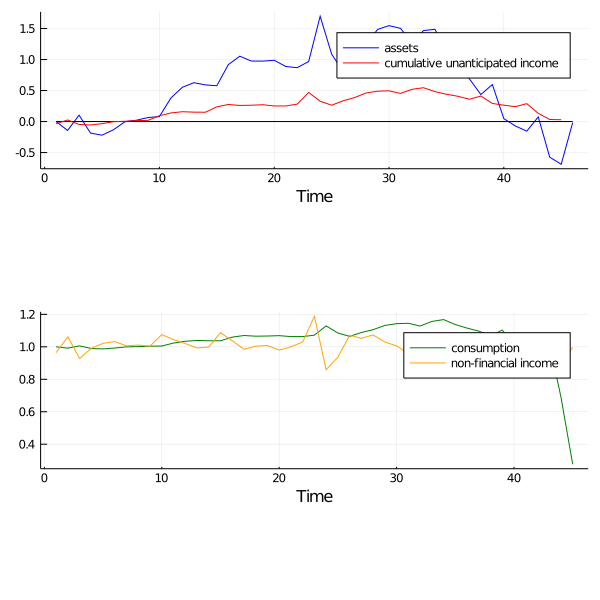

In [3]:
# model parameters
r = 0.05
β = 1 / (1 + r)
T = 45
c̄ = 2.0
σ = 0.25
μ = 1.0
q = 1e6

# formulate as an LQ problem
Q = 1.0
R = zeros(2, 2)
Rf = zeros(2, 2); Rf[1, 1] = q
A = [1 + r -c̄ + μ; 0  1]
B = [-1.0, 0]
C = [σ, 0]

# compute solutions and simulate
lq = QuantEcon.LQ(Q, R, A, B, C; bet = β, capT = T, rf = Rf)
x0 = [0.0, 1]
xp, up, wp = compute_sequence(lq, x0)

# convert back to assets, consumption and income
assets = vec(xp[1, :]) # a_t
c = vec(up .+ c̄) # c_t
income = vec(σ * wp[1, 2:end] .+ μ) # y_t

# plot results
p = plot([assets, c, zeros(T + 1), income, cumsum(income .- μ)],
         lab = ["assets" "consumption" "" "non-financial income" "cumulative unanticipated income"],
         color = [:blue :green :black :orange :red],
         xaxis = "Time", layout = (2, 1),
         bottom_margin = 20mm, size = (600, 600))

The top panel shows the time path of consumption $ c_t $ and income $ y_t $ in the simulation.

As anticipated by the discussion on consumption smoothing, the time path of
consumption is much smoother than that for income.

(But note that  consumption becomes more irregular towards the end of life,
when the zero final asset requirement impinges more on consumption choices).

The second panel in the figure shows that the time path of assets $ a_t $ is
closely correlated with cumulative unanticipated income, where the latter is defined as

$$
z_t := \sum_{j=0}^t \sigma w_t
$$

A key message is that unanticipated windfall gains are saved rather
than consumed, while unanticipated negative shocks are met by reducing assets.

(Again, this relationship breaks down towards the end of life due to the zero final asset requirement).

These results are relatively robust to changes in parameters.

For example, let’s increase $ \beta $ from $ 1 / (1 + r) \approx 0.952 $ to $ 0.96 $ while keeping other parameters fixed.

This consumer is slightly more patient than the last one, and hence puts
relatively more weight on later consumption values

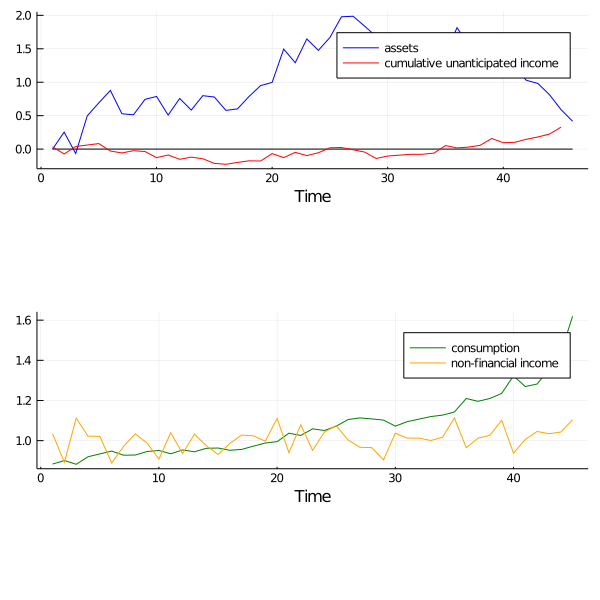

In [4]:
# compute solutions and simulate
lq = QuantEcon.LQ(Q, R, A, B, C; bet = 0.96, capT = T, rf = Rf)
x0 = [0.0, 1]
xp, up, wp = compute_sequence(lq, x0)

# convert back to assets, consumption and income
assets = vec(xp[1, :]) # a_t
c = vec(up .+ c̄) # c_t
income = vec(σ * wp[1, 2:end] .+ μ) # y_t

# plot results
p = plot([assets, c, zeros(T + 1), income, cumsum(income .- μ)],
         lab = ["assets" "consumption" "" "non-financial income" "cumulative unanticipated income"],
         color = [:blue :green :black :orange :red],
         xaxis = "Time", layout = (2, 1),
         bottom_margin = 20mm, size = (600, 600))

We now have a slowly rising consumption stream and a hump-shaped build
up of assets in the middle periods to fund rising consumption.

However, the essential features are the same: consumption is smooth relative to income, and assets are strongly positively correlated with cumulative unanticipated income.

## Extensions and Comments

Let’s now consider a number of standard extensions to the LQ problem treated above.

### Time-Varying Parameters

In some settings it can be desirable to allow $ A, B, C, R $ and $ Q $ to depend on $ t $.

For the sake of simplicity, we’ve chosen not to treat this extension in our implementation given below.

However, the loss of generality is not as large as you might first imagine.

In fact, we can tackle many models with time-varying parameters by suitable choice of state variables.

One illustration is given [below](#lq-nsi).

For further examples and a more systematic treatment, see [[HS13]](../zreferences.html#hansensargent2013), section 2.4.


<a id='lq-cpt'></a>

### Adding a Cross-Product Term

In some LQ problems, preferences include a cross-product term $ u_t' N x_t $, so that the objective function becomes


<a id='equation-lq-object-cp'></a>
$$
\mathbb E \,
\left\{
    \sum_{t=0}^{T-1} \beta^t (x_t' R x_t + u_t' Q u_t + 2 u_t' N x_t) + \beta^T x_T' R_f x_T
\right\} \tag{17}
$$

Our results extend to this case in a straightforward way.

The sequence $ \{P_t\} $ from [(12)](#equation-lq-pr) becomes


<a id='equation-lq-pr-cp'></a>
$$
P_{t-1}
= R - (\beta B' P_t A + N)' (Q + \beta B' P_t B)^{-1} (\beta B' P_t A + N) +
\beta A' P_t A
\quad \text{with } \quad
P_T = R_f \tag{18}
$$

The policies in [(14)](#equation-lq-oc) are modified to


<a id='equation-lq-oc-cp'></a>
$$
u_t  = - F_t x_t
\quad \text{where} \quad
F_t := (Q + \beta B' P_{t+1} B)^{-1} (\beta B' P_{t+1} A + N) \tag{19}
$$

The sequence $ \{d_t\} $ is unchanged from [(13)](#equation-lq-dd).

We leave interested readers to confirm these results (the calculations are long but not overly difficult).


<a id='lq-ih'></a>

### Infinite Horizon


<a id='index-2'></a>
Finally, we consider the infinite horizon case, with [cross-product term](#lq-cpt), unchanged dynamics and
objective function given by


<a id='equation-lq-object-ih'></a>
$$
\mathbb E \,
\left\{
    \sum_{t=0}^{\infty} \beta^t (x_t' R x_t + u_t' Q u_t + 2 u_t' N x_t)
\right\} \tag{20}
$$

In the infinite horizon case, optimal policies can depend on time
only if time itself is a component of the  state vector $ x_t $.

In other words, there exists a fixed matrix $ F $ such that $ u_t = -
F x_t $ for all $ t $.

That decision rules are constant over time is intuitive — after all, the decision maker faces the
same infinite horizon at every stage, with only the current state changing.

Not surprisingly, $ P $ and $ d $ are also constant.

The stationary matrix $ P $ is the solution to the
[discrete time algebraic Riccati equation](https://en.wikipedia.org/wiki/Algebraic_Riccati_equation).


<a id='riccati-equation'></a>

<a id='equation-lq-pr-ih'></a>
$$
P = R - (\beta B' P A + N)' (Q + \beta B' P B)^{-1} (\beta B' P A + N) +
\beta A' P A \tag{21}
$$

Equation [(21)](#equation-lq-pr-ih) is also called the *LQ Bellman equation*, and the map
that sends a given $ P $ into the right-hand side of [(21)](#equation-lq-pr-ih) is
called the *LQ Bellman operator*.

The stationary optimal policy for this model is


<a id='equation-lq-oc-ih'></a>
$$
u  = - F x
\quad \text{where} \quad
F = (Q + \beta B' P B)^{-1} (\beta B' P A + N) \tag{22}
$$

The sequence $ \{d_t\} $ from [(13)](#equation-lq-dd) is replaced by the constant value


<a id='equation-lq-dd-ih'></a>
$$
d
:= \mathop{\mathrm{trace}}(C' P C) \frac{\beta}{1 - \beta} \tag{23}
$$

The state evolves according to the time-homogeneous process $ x_{t+1} = (A - BF) x_t + C w_{t+1} $.

An example infinite horizon problem is treated [below](#lqc-mwac).


<a id='lq-cert-eq'></a>

### Certainty Equivalence

Linear quadratic control problems of the class discussed above have the property of *certainty equivalence*.

By this we mean that the optimal policy $ F $ is not affected by the parameters in $ C $, which specify the shock process.

This can be confirmed by inspecting [(22)](#equation-lq-oc-ih) or [(19)](#equation-lq-oc-cp).

It follows that we can ignore uncertainty when solving for optimal behavior, and plug it back in when examining optimal state dynamics.

## Further Applications


<a id='lq-nsi'></a>

### Application 1: Age-Dependent Income Process

[Previously](#lq-mfpa) we studied a permanent income model that generated consumption smoothing.

One unrealistic feature of that model is the assumption that the mean of the random income process does not depend on the consumer’s age.

A more realistic income profile is one that rises in early working life, peaks towards the middle and maybe declines toward end of working life, and falls more during retirement.

In this section, we will model this rise and fall as a symmetric inverted “U” using a polynomial in age.

As before, the consumer seeks to minimize


<a id='equation-lq-pip'></a>
$$
\mathbb E \,
\left\{
    \sum_{t=0}^{T-1} \beta^t (c_t - \bar c)^2 + \beta^T q a_T^2
\right\} \tag{24}
$$

subject to $ a_{t+1} = (1 + r) a_t - c_t + y_t, \ t \geq 0 $.

For income we now take $ y_t = p(t) + \sigma w_{t+1} $ where $ p(t) := m_0 + m_1 t + m_2 t^2 $.

(In [the next section](#lq-nsi2) we employ some tricks to implement a more sophisticated model).

The coefficients $ m_0, m_1, m_2 $ are chosen such that $ p(0)=0, p(T/2) = \mu, $ and $ p(T)=0 $.

You can confirm that the specification $ m_0 = 0, m_1 = T \mu / (T/2)^2, m_2 = - \mu / (T/2)^2 $ satisfies these constraints.

To put this into an LQ setting, consider the budget constraint, which becomes


<a id='equation-lq-hib'></a>
$$
a_{t+1} = (1 + r) a_t - u_t - \bar c + m_1 t + m_2 t^2 + \sigma w_{t+1} \tag{25}
$$

The fact that $ a_{t+1} $ is a linear function of
$ (a_t, 1, t, t^2) $ suggests taking these four variables as the state
vector $ x_t $.

Once a good choice of state and control (recall $ u_t = c_t - \bar c $)
has been made, the remaining specifications fall into place relatively easily.

Thus, for the dynamics we set


<a id='equation-lq-lowmc3'></a>
$$
x_t :=
\left(
\begin{array}{c}
a_t \\
1 \\
t \\
t^2
\end{array}
\right),
\quad
A :=
\left(
\begin{array}{cccc}
1 + r & -\bar c & m_1 & m_2 \\
0     & 1       & 0   & 0   \\
0     & 1       & 1   & 0   \\
0     & 1       & 2   & 1   \\
\end{array}
\right),
\quad
B :=
\left(
\begin{array}{c}
-1 \\
0 \\
0 \\
0
\end{array}
\right),
\quad
C :=
\left(
\begin{array}{c}
\sigma \\
0 \\
0 \\
0
\end{array}
\right) \tag{26}
$$

If you expand the expression $ x_{t+1} = A x_t + B u_t + C w_{t+1} $ using
this specification, you will find that assets follow [(25)](#equation-lq-hib) as desired,
and that the other state variables also update appropriately.

To implement preference specification [(24)](#equation-lq-pip) we take


<a id='equation-lq-4sp'></a>
$$
Q := 1,
\quad
R :=
\left(
\begin{array}{cccc}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{array}
\right)
\quad \text{and} \quad
R_f :=
\left(
\begin{array}{cccc}
q & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{array}
\right) \tag{27}
$$

The next figure shows a simulation of consumption and assets computed using
the `compute_sequence` method of `lqcontrol.jl` with initial assets set to zero.


<a id='solution-lqc-ex1-fig'></a>
<img src="_static/figures/solution_lqc_ex1.png" style="">

  
Once again, smooth consumption is a dominant feature of the sample  paths.

The asset path exhibits dynamics consistent with standard life cycle theory.

Exercise 1 gives the full set of parameters used here and asks you to replicate the figure.


<a id='lq-nsi2'></a>

### Application 2: A Permanent Income Model with Retirement

In the [previous application](#lq-nsi), we generated income dynamics with an inverted U shape using polynomials, and placed them in an LQ framework.

It is arguably the case that this income process still contains unrealistic features.

A more common earning profile is where

1. income grows over working life, fluctuating around an increasing trend, with growth flattening off in later years  
1. retirement follows, with lower but relatively stable (non-financial) income  


Letting $ K $ be the retirement date, we can express these income dynamics
by


<a id='equation-lq-cases'></a>
$$
y_t =
\begin{cases}
p(t) + \sigma w_{t+1} & \quad \text{if } t \leq K  \\
s                     & \quad \text{otherwise }  \\
\end{cases} \tag{28}
$$

Here

- $ p(t) := m_1 t + m_2 t^2 $ with the coefficients $ m_1, m_2 $ chosen such that $ p(K) = \mu $ and $ p(0) = p(2K)=0 $  
- $ s $ is retirement income  


We suppose that preferences are unchanged and given by [(16)](#equation-lq-pio).

The budget constraint is also unchanged and given by $ a_{t+1} = (1 + r) a_t - c_t + y_t $.

Our aim is to solve this problem and simulate paths using the LQ techniques described in this lecture.

In fact this is a nontrivial problem, as the kink in the dynamics [(28)](#equation-lq-cases) at $ K $ makes it very difficult to express the law of motion as a fixed-coefficient linear system.

However, we can still use our LQ methods here by suitably linking two component LQ problems.

These two LQ problems describe the consumer’s behavior during her working life (`lq_working`) and retirement (`lq_retired`).

(This is possible because in the two separate periods of life, the respective income processes
[polynomial trend and constant] each fit the LQ framework)

The basic idea is that although the whole problem is not a single time-invariant LQ problem, it is
still a dynamic programming problem, and hence we can use appropriate Bellman equations at
every stage.

Based on this logic, we can

1. solve `lq_retired` by the usual backwards induction procedure, iterating back to the start of retirement  
1. take the start-of-retirement value function generated by this process, and use it as  the terminal condition $ R_f $ to feed into the `lq_working` specification  
1. solve `lq_working` by backwards induction from this choice of $ R_f $, iterating back to the start of working life  


This process gives the entire life-time sequence of value functions and optimal policies.

The next figure shows one simulation based on this procedure.


<a id='solution-lqc-ex2-fig'></a>
<img src="_static/figures/solution_lqc_ex2.png" style="">

  
The full set of parameters used in the simulation is discussed in [Exercise 2](#lqc-ex2), where you are asked to replicate the figure.

Once again, the dominant feature observable in the simulation is consumption
smoothing.

The asset path fits well with standard life cycle theory, with dissaving early
in life followed by later saving.

Assets peak at retirement and subsequently decline.


<a id='lqc-mwac'></a>

### Application 3: Monopoly with Adjustment Costs

Consider a monopolist facing stochastic inverse demand function

$$
p_t = a_0 - a_1 q_t + d_t
$$

Here $ q_t $ is output, and the demand shock $ d_t $ follows

$$
d_{t+1} = \rho d_t + \sigma w_{t+1}
$$

where $ \{w_t\} $ is iid and standard normal.

The monopolist maximizes the expected discounted sum of present and future profits


<a id='equation-lq-object-mp'></a>
$$
\mathbb E \,
\left\{
    \sum_{t=0}^{\infty} \beta^t
    \pi_t
\right\}
\quad \text{where} \quad
\pi_t := p_t q_t - c q_t - \gamma (q_{t+1} - q_t)^2 \tag{29}
$$

Here

- $ \gamma (q_{t+1} - q_t)^2 $ represents adjustment costs  
- $ c $ is average cost of production  


This can be formulated as an LQ problem and then solved and simulated,
but first let’s study the problem and try to get some intuition.

One way to start thinking about the problem is to consider what would happen
if $ \gamma = 0 $.

Without adjustment costs there is no intertemporal trade-off, so the
monopolist will choose output to maximize current profit in each period.

It’s not difficult to show that profit-maximizing output is

$$
\bar q_t := \frac{a_0 - c + d_t}{2 a_1}
$$

In light of this discussion, what we might expect for general $ \gamma $ is that

- if $ \gamma $ is close to zero, then $ q_t $ will track the time path of $ \bar q_t $ relatively closely  
- if $ \gamma $ is larger, then $ q_t $ will be smoother than $ \bar q_t $, as the monopolist seeks to avoid adjustment costs  


This intuition turns out to be correct.

The following figures show simulations produced by solving the corresponding LQ problem.

The only difference in parameters across the figures is the size of $ \gamma $.

<img src="_static/figures/solution_lqc_ex3_g1.png" style="">

  
<img src="_static/figures/solution_lqc_ex3_g10.png" style="">

  
<img src="_static/figures/solution_lqc_ex3_g50.png" style="">

  
To produce these figures we converted the monopolist problem into an LQ problem.

The key to this conversion is to choose the right state — which can be a bit of an art.

Here we take $ x_t = (\bar q_t \;\, q_t \;\, 1)' $, while the control is chosen as $ u_t = q_{t+1} - q_t $.

We also manipulated the profit function slightly.

In [(29)](#equation-lq-object-mp), current profits are $ \pi_t := p_t q_t - c q_t - \gamma (q_{t+1} - q_t)^2 $.

Let’s now replace $ \pi_t $ in [(29)](#equation-lq-object-mp) with $ \hat \pi_t := \pi_t - a_1 \bar q_t^2 $.

This makes no difference to the solution, since $ a_1 \bar q_t^2 $ does not depend on the controls.

(In fact we are just adding a constant term to [(29)](#equation-lq-object-mp), and optimizers are not affected by constant terms)

The reason for making this substitution is that, as you will be able to
verify, $ \hat \pi_t $ reduces to the simple quadratic

$$
\hat \pi_t = -a_1 (q_t - \bar q_t)^2 - \gamma u_t^2
$$

After negation to convert to a minimization problem, the objective becomes


<a id='equation-lq-object-mp2'></a>
$$
\min
\mathbb E \,
    \sum_{t=0}^{\infty} \beta^t
\left\{
    a_1 ( q_t - \bar q_t)^2 + \gamma u_t^2
\right\} \tag{30}
$$

It’s now relatively straightforward to find $ R $ and $ Q $ such that
[(30)](#equation-lq-object-mp2) can be written as [(20)](#equation-lq-object-ih).

Furthermore, the matrices $ A, B $ and $ C $ from [(1)](#equation-lq-lom)
can be found by writing down the dynamics of each element of the state.

[Exercise 3](#lqc-ex3) asks you to complete this process, and reproduce the preceding figures.

## Exercises


<a id='lqc-ex1'></a>

### Exercise 1

Replicate the figure with polynomial income [shown above](#solution-lqc-ex1-fig).

The parameters are $ r = 0.05, \beta = 1 / (1 + r), \bar c = 1.5,  \mu = 2, \sigma = 0.15, T = 50 $ and $ q = 10^4 $.


<a id='lqc-ex2'></a>

### Exercise 2

Replicate the figure on work and retirement [shown above](#solution-lqc-ex2-fig).

The parameters are $ r = 0.05, \beta = 1 / (1 + r), \bar c = 4,  \mu = 4, \sigma = 0.35, K = 40, T = 60, s = 1 $ and $ q = 10^4 $.

To understand the overall procedure, carefully read the section containing that figure.

Some hints are as follows:

First, in order to make our approach work, we must ensure that both LQ problems have the same state variables and control.

As with previous applications, the control can be set to $ u_t = c_t - \bar c $.

For `lq_working`, $ x_t, A, B, C $ can be chosen as in [(26)](#equation-lq-lowmc3).

- Recall that $ m_1, m_2 $ are chosen so that $ p(K) = \mu $ and $ p(2K)=0 $.  


For `lq_retired`, use the same definition of $ x_t $ and $ u_t $, but modify $ A, B, C $ to correspond to constant income $ y_t = s $.

For `lq_retired`, set preferences as in [(27)](#equation-lq-4sp).

For `lq_working`, preferences are the same, except that $ R_f $ should
be replaced by the final value function that emerges from iterating `lq_retired`
back to the start of retirement.

With some careful footwork, the simulation can be generated by patching
together the simulations from these two separate models.


<a id='lqc-ex3'></a>

### Exercise 3

Reproduce the figures from the monopolist application [given above](#lqc-mwac).

For parameters, use $ a_0 = 5, a_1 = 0.5, \sigma = 0.15, \rho = 0.9,
\beta = 0.95 $ and $ c = 2 $, while $ \gamma $ varies between 1 and 50
(see figures).

## Solutions

### Exercise 1

Here’s one solution.

We use some fancy plot commands to get a certain style — feel free to
use simpler ones.

The model is an LQ permanent income / life-cycle model with hump-shaped
income.

$$
y_t = m_1 t + m_2 t^2 + \sigma w_{t+1}
$$

where $ \{w_t\} $ is iid $ N(0, 1) $ and the coefficients
$ m_1 $ and $ m_2 $ are chosen so that
$ p(t) = m_1 t + m_2 t^2 $ has an inverted U shape with

- $ p(0) = 0, p(T/2) = \mu $, and  
- $ p(T) = 0 $.  

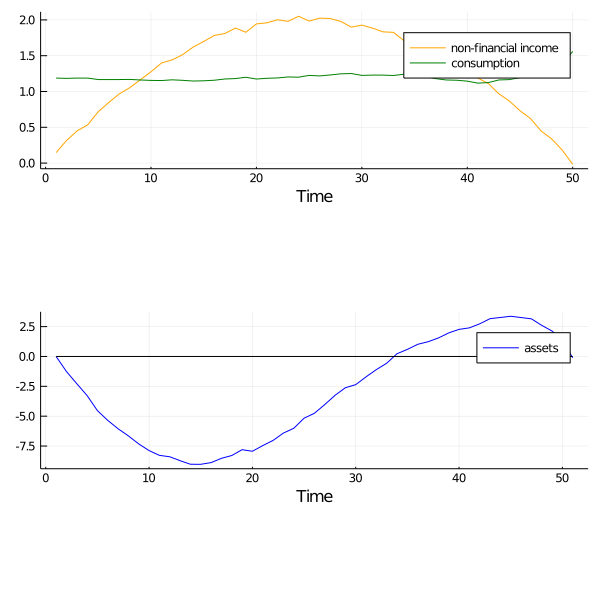

In [5]:
# model parameters
r = 0.05
β = 1 / (1 + r)
T = 50
c̄ = 1.5
σ = 0.15
μ = 2
q = 1e4
m1 = T * (μ / (T / 2)^2)
m2 = -(μ / (T / 2)^2)

# formulate as an LQ problem
Q = 1.0
R = zeros(4, 4)
Rf = zeros(4, 4); Rf[1, 1] = q
A = [1 + r -c̄ m1 m2;
     0     1      0  0;
     0     1      1  0;
     0     1      2  1]
B = [-1.0, 0.0, 0.0, 0.0]
C = [σ, 0.0, 0.0, 0.0]

# compute solutions and simulate
lq = QuantEcon.LQ(Q, R, A, B, C; bet = β, capT = T, rf = Rf)
x0 = [0.0, 1, 0, 0]
xp, up, wp = compute_sequence(lq, x0)

# convert results back to assets, consumption and income
ap = vec(xp[1, 1:end]) # assets
c = vec(up .+ c̄) # consumption
time = 1:T
income = σ * vec(wp[1, 2:end]) + m1 * time + m2 * time.^2 # income

# plot results
p1 = plot(Vector[income, ap, c, zeros(T + 1)],
          lab = ["non-financial income" "assets" "consumption" ""],
          color = [:orange :blue :green :black],
          xaxis = "Time", layout = (2,1),
          bottom_margin = 20mm, size = (600, 600))

### Exercise 2

This is a permanent income / life-cycle model with polynomial growth in
income over working life followed by a fixed retirement income. The
model is solved by combining two LQ programming problems as described in
the lecture.

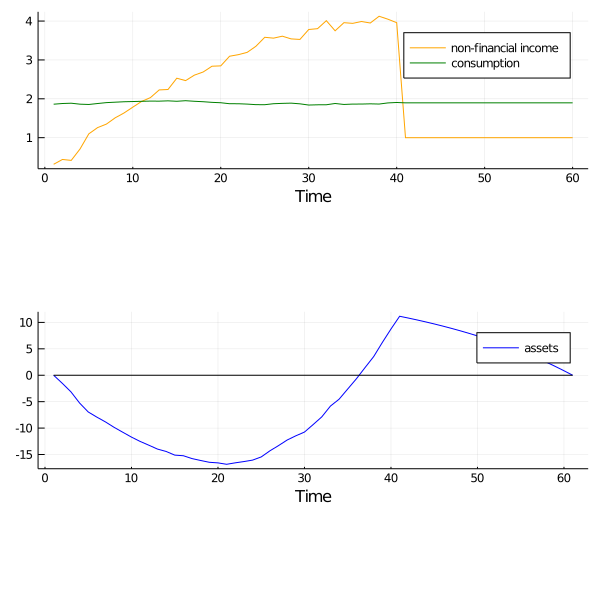

In [6]:
# model parameters
r = 0.05
β = 1/(1 + r)
T = 60
K = 40
c̄ = 4
σ = 0.35
μ = 4
q = 1e4
s = 1
m1 = 2 * μ / K
m2 = - μ / K^2

# formulate LQ problem 1 (retirement)
Q = 1.0
R = zeros(4, 4)
Rf = zeros(4, 4); Rf[1, 1] = q
A = [1+r  s-c̄ 0 0;
     0     1      0 0;
     0     1      1 0;
     0     1      2 1]
B = [-1.0, 0, 0, 0]
C = zeros(4)

# initialize LQ instance for retired agent
lq_retired = QuantEcon.LQ(Q, R, A, B, C; bet = β, capT = T - K, rf = Rf)

# since update_values!() changes its argument in place, we need another identical instance
# just to get the correct value function
lq_retired_proxy = QuantEcon.LQ(Q, R, A, B, C; bet = β, capT = T - K, rf = Rf)

# iterate back to start of retirement, record final value function
for i in 1:(T - K)
    update_values!(lq_retired_proxy)
end
Rf2 = lq_retired_proxy.P

# formulate LQ problem 2 (working life)
Q = 1.0
R = zeros(4, 4)
A = [1 + r -c̄ m1 m2;
     0     1      0  0;
     0     1      1  0;
     0     1      2  1]
B = [-1.0, 0, 0, 0]
C = [σ, 0, 0, 0]

# set up working life LQ instance with terminal Rf from lq_retired
lq_working = QuantEcon.LQ(Q, R, A, B, C; bet = β, capT = K, rf = Rf2)

# simulate working state / control paths
x0 = [0.0, 1, 0, 0]
xp_w, up_w, wp_w = compute_sequence(lq_working, x0)

# simulate retirement paths (note the initial condition)
xp_r, up_r, wp_r = compute_sequence(lq_retired, xp_w[:, end])

# convert results back to assets, consumption and income
xp = [xp_w xp_r[:, 2:end]]
assets = vec(xp[1, :]) # assets

up = [up_w up_r]
c = vec(up .+ c̄) # consumption

time = 1:K
income_w = σ * vec(wp_w[1, 2:K+1]) + m1 .* time + m2 .* time.^2 # income
income_r = ones(T - K) * s
income = [income_w; income_r]

# plot results
p2 = plot([income, assets, c, zeros(T + 1)],
          lab = ["non-financial income" "assets" "consumption" ""],
          color = [:orange :blue :green :black],
          xaxis = "Time", layout = (2, 1),
          bottom_margin = 20mm, size = (600, 600))

### Exercise 3

The first task is to find the matrices $ A, B, C, Q, R $ that define
the LQ problem.

Recall that $ x_t = (\bar q_t \;\, q_t \;\, 1)' $, while
$ u_t = q_{t+1} - q_t $.

Letting $ m_0 := (a_0 - c) / 2a_1 $ and $ m_1 := 1 / 2 a_1 $, we
can write $ \bar q_t = m_0 + m_1 d_t $, and then, with some
manipulation

$$
\bar q_{t+1} = m_0 (1 - \rho) + \rho \bar q_t + m_1 \sigma w_{t+1}
$$

By our definition of $ u_t $, the dynamics of $ q_t $ are
$ q_{t+1} = q_t + u_t $.

Using these facts you should be able to build the correct
$ A, B, C $ matrices (and then check them against those found in the
solution code below).

Suitable $ R, Q $ matrices can be found by inspecting the objective
function, which we repeat here for convenience:

$$
\min
\mathbb E \,
\left\{
    \sum_{t=0}^{\infty} \beta^t
    a_1 ( q_t - \bar q_t)^2 + \gamma u_t^2
\right\}
$$

Our solution code is

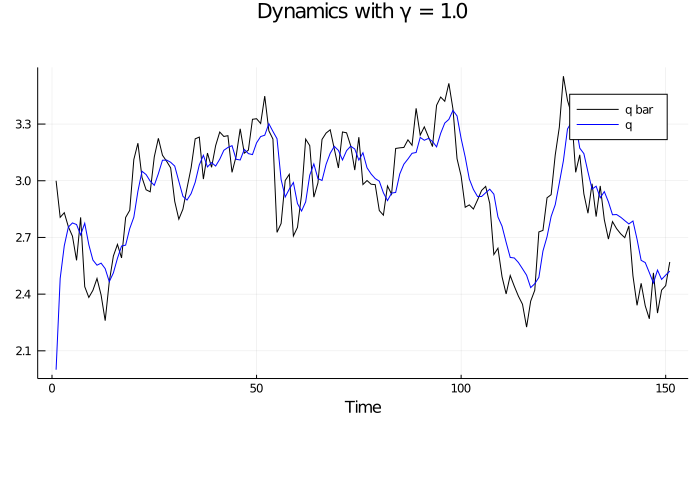

In [7]:
# model parameters
a0 = 5.0
a1 = 0.5
σ = 0.15
ρ = 0.9
γ = 1.0
β = 0.95
c = 2.0
T = 120

# useful constants
m0 = (a0 - c) / (2 * a1)
m1 = 1 / (2 * a1)

# formulate LQ problem
Q = γ
R = [a1 -a1 0; -a1 a1 0; 0 0 0]
A = [ρ 0 m0 * (1 - ρ); 0 1 0; 0 0 1]

B = [0.0, 1, 0]
C = [m1 * σ, 0, 0]

lq = QuantEcon.LQ(Q, R, A, B, C; bet = β)

# simulate state / control paths
x0 = [m0, 2, 1]
xp, up, wp = compute_sequence(lq, x0, 150)
q̄ = vec(xp[1, :])
q = vec(xp[2, :])

# plot simulation results
p3 = plot(eachindex(q), [q̄ q],
          lab = ["q bar" "q"],
          color = [:black :blue],
          xaxis = "Time", title = "Dynamics with γ = $γ",
          bottom_margin = 20mm, top_margin = 10mm,
          size = (700, 500))